<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_23/blob/master/Lectures/08-decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2023

**Lecture 08**

In this note we will explore tree models for classification and regression. First, we will learn about the Decision Tree: a fast, and quite accurate model that is also interpretable.
Next, we will explore ensembles of trees, especially two very popular variants:
- the Random Forest, a very robust and easy to use classifier
- Boosted trees, a state-of-the art tree classifier which wins nearly half of kaggle competitions (the other half is won using convolutional neural networks, and I invite you to my deep learning course to learn about them!)

We will begin with an intuitive explanation of what are decision trees.

Let's once again load the Iris dataset, and make yet another attempt at telling the flowers from each other!

In [1]:
import os
import sys

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.linear_model
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib import rc
from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split
from statsmodels.stats.proportion import proportion_confint

from graphviz import Digraph

with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

<AxesSubplot:xlabel='petal length (cm)', ylabel='petal width (cm)'>

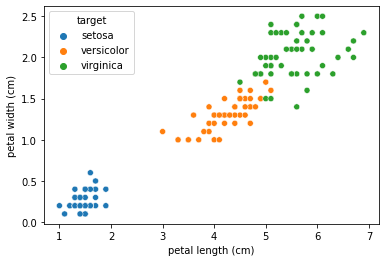

In [2]:
# Load Iris data
iris = sklearn.datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["target"] = pd.Categorical(iris.target_names[iris.target])


# Load Mushroom data
# fmt:off
columns = [
 "target", "cap-shape", "cap-surface", "cap-color", "bruises?", "odor", 
 "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", 
 "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
 "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", 
 "ring-number", "ring-type", "spore-print-color", "population", "habitat", ]
# fmt:on
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
# Special dataset - we add the row number (index) as an extra feature
mushroom_idx_df = mushroom_df.reset_index()
mushroom_idx_df["index_col"] = [str(i) for i in mushroom_idx_df.index]

# Load old US Congress voting data
vote_df = (
    pd.read_csv(
        "https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv"
    )
    .rename({"Class": "target"}, axis=1)
    .fillna("na")
)

# Finally replot the Iris data
sns.scatterplot(data=iris_df, x="petal length (cm)", y="petal width (cm)", hue="target")

## Decision Tree Intuitions

Looking at the plot above, we could e.g. write the following set of conditions to classify irises:

```python
if petal_length < 2.5:
    return 'Setosa'
else:
    if petal_width > 1.8:
        return 'Virginica'
    else:
        if petal_length < 5.2:
            return 'Versicolor'
        else:
            return 'Virginica'

```

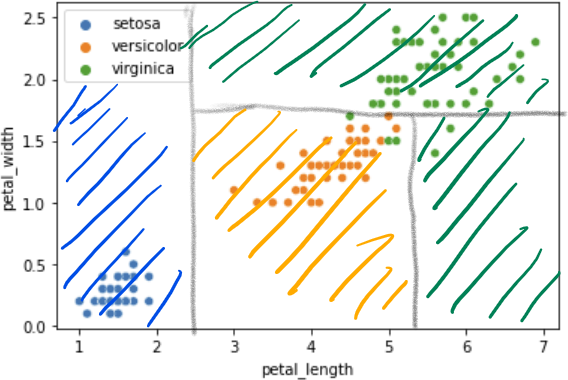

The `if-else` tree yields a separation of the data as shown above.

We can observe a few facts:
1. Each `if` makes a cut of the space.
2. Each cut is parallel to an axis.
3. The full tree divides the whole space into boxes.
4. The contents of each box are assigned to one class.
5. A deep `if-else` tree may place one box around each datapoint, resulting in perfect data classification.

We will henceforth call the `if-else` tree a _Decision Tree_. A decision tree is a rooted tree in which:
1. All internal nodes contain a data split,
2. Leaf nodes classify the data.

A sufficiently deep decision tree will always yield a 100% training classification accuracy (provided no two data samples with conflicting classes have exactly the same features). However, a good tree should also have a good predictive accurracy. It is typically assummed that if a shallow tree does well on the training data, it will also generalize well. Our goal is thus to find trees which are small, and have good performance on the training set. Small trees are also interpretable - they can be shown to humans and reasoned about.

Unfortunately, exactly finding the smallest tree with a given training accurracy is a difficult combinatorial problem. However, the following greedy algorithm often works surprisingly well:

```python
def build_tree(D: Dataset):
    """Build a Decision Tree until leaves are pure."""
    if D contains samples from one class:
        return LeafNode(D)
    else:
        1. choose a splitting criterion c
        2. split D into two subsets:
            - D_true containing samples from D on which c is True
            - D_false containing samples from D on which c is False
        return SplitNode(c, build_tree(D_true), build_tree(D_false))
```

The algorithm first inspects the data sample on which it is called. If the sample is _pure_, i.e. it contains samples from one class only, a leaf node is created.

If the node is impure, a splitting criterion (also called test) is selected. It divides the training data into two (sometimes more) parts. Hopefully, these subsets are purer. The algorithm recursively builds trees on the subsets, then adds a `SplitNode`.

To turn the pseudocode above into a full tree-building algorithm, we need to specify the set of available splitting criteria and a selection method.
Since choosing the best split requires computing the outcomes of all tests under consideration, pracitcal algorithms typically limit the choice to only a couple of possiblities:
1. For categorical (discrete) variables, do one of:
    - introduce a subtree for each value the feature may take (used in C4.5)
    - separate one value from the others
    - split the values into two groups (CART's approach)
2. For continuous variables a splitting criterion is a threshold: values below it go to one branch, and values above it go to the other one.

### Purity criterion

A good split should result in subtrees which are purer that their parent node. For our first try, we will measure data impurity as the error rate of a majority classifier. 

Let $\pi_c = p(y=c|t)$ be the class distribution in tree node $t$. Then the misclassification rate is
$$
i_E(t) = 1-\max_{c}\pi_c
$$

Below we show the missclasification for a node containing a mixture of two classes.

Text(0.5, 0, 'Class balance')

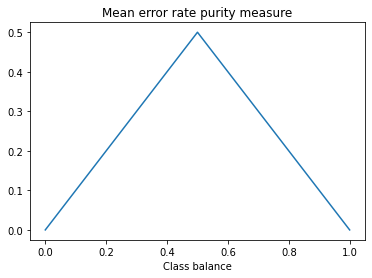

In [3]:
def mean_err_rate(counts):
    """Compute the error rate of a majority classifier.
    
    Counts is a pandas.Series which gives the counts of all possible target values.
    """
    s = counts.sum()
    p = counts / s
    return 1 - p.max()


fractions = np.linspace(0, 1, 101)
# We have to do a for loop, because we will be supplying pandas series later on
err_rates = [mean_err_rate(np.array([f, 1.0-f])) for f in fractions]
plt.plot(fractions, err_rates)
plt.title("Mean error rate purity measure")
plt.xlabel("Class balance")

From the plot above we can see, that the error rate is zero for pure datasets and linearly rises to 0.5 for a dataset with equal proportions of two classes.

This linear increase of impurity is, however, undesirable. Consider again the iris dataset. Intuitively, the best threshold along the `petal length` feature would separate the setosas from the other species. This results in the following subtrees:

|                    | setosa | versicolor | virginica | mean_error_rate |
|:------------------:|:------:|:----------:|:---------:|:---------------:|
| petal length $\leq 2.5$ | 50     | 0          | 0         | $\frac{0}{50}$ |
| petal length $> 2.5$ | 0     | 50          | 50         | $\frac{50}{100}$ |

The weighted purity for this split is $\frac{50\frac{0}{50} + 100\frac{50}{100}}{150}=0.33$

However, now consider a split which setarates all setosas, but mixes them with some versicolors:

|                    | setosa | versicolor | virginica | mean_error_rate |
|:------------------:|:------:|:----------:|:---------:|:---------------:|
| petal length $\leq 4$ | 50     | 11          | 0         | $\frac{11}{61}$ |
| petal length $> 4$ | 0     | 39          | 50         | $\frac{39}{89}$ |

The weighted purity for this split is $\frac{61\frac{11}{61} + 89\frac{39}{89}}{150}=0.33$.

The mean error rate criterion doesn't differentiate between these two splits! The problem is, that for a wide range of values a change of the threshold moves erroneous samples from one subset to the other, however the total error count is unchanged, and the mean accurracy criterion doesn't differentiate between them.

We can see this problem on the plot below: the minimum error rate spans a range of thresholds, without a clear indication which one should be selected.



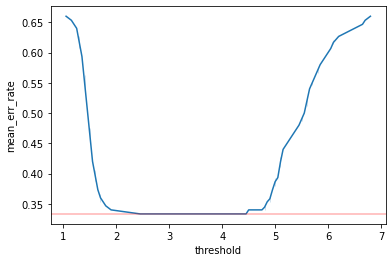

In [4]:
def plot_numerical_split_purity(df, feature, purity_measure):
    """Get the best split for a numerical variable.

    Iterate over all possible thresholds, and record the mean purity of the split.
    """
    measure_name = purity_measure.__name__
    df_sorted = df.sort_values(feature)

    # Class counts
    counts_above_th = df_sorted.target.value_counts()
    counts_below_th = 0 * counts_above_th

    mean_impurities = []

    old_threshold = df_sorted[feature].iloc[0]
    for _, row in df_sorted.iterrows():
        threshold = row[feature]
        err_rate_below_th = purity_measure(counts_below_th)
        err_rate_above_th = purity_measure(counts_above_th)

        mean_impurities.append(
            {
                # put the threshold between two data points
                "threshold": 0.5 * (old_threshold + threshold),
                # awerage child purities weighting by their size
                measure_name: (
                    err_rate_below_th * counts_below_th.sum()
                    + err_rate_above_th * counts_above_th.sum()
                )
                / len(df_sorted),
            }
        )
        old_threshold = threshold

        # Now get the target class and move one sample from the subset above the
        # threshold to the subset below it
        counts_below_th[row["target"]] += 1
        counts_above_th[row["target"]] -= 1

    mean_impurities = pd.DataFrame(mean_impurities)
    sns.lineplot(data=mean_impurities, x="threshold", y=measure_name)
    min_imp = mean_impurities[measure_name].min()
    plt.axhline(min_imp, color="r", alpha=0.3)


plot_numerical_split_purity(iris_df, "petal length (cm)", mean_err_rate)

### Practical purity measures

We need a criterion in which the tree impurity increases faster than linearly. Two possibilities, which have been developed respectively in the statistical and machine learning communities and which have been extensively used are the Gini Impurity $i_G$ and Entropy $i_H$. Recall that $\pi_c = p(y=c|t)$ is the class distribution in tree node $t$. The measures are:
- the [Gini Impurity measure](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)
    $$
    i_G(t) = \sum_{c}\pi_c(1-\pi_c) = 1-\sum_c\pi_c^2
    $$
    
    the Gini coefficient can be interpreted as the average number of errors introduced, when we change the class of each element to the class of another one. The purer the node, the more often the exchange will do nothing, in particular for pure nodes the Gini impurity is 0.

- the [Entropy](https://en.wikipedia.org/wiki/Entropy)
    $$
    i_H(t) = -\sum_c\pi_c\log\pi_c
    $$

    where we assume that $\lim_{x\rightarrow 0+} x\log x=0$.

    The reduction of the entropy, i.e. the difference between the entropy of a parent node and the mean entropy of its children is called the [Information Gain](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurityInformation_gain), which is equivalent to the [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) between the binary variable describing the split and the targets. It is often use as a dependency measure for feature selection.

The plot below compares the three impurity measures. We can see that all are concave, hovewer for Gini and Entropy the change of the measure doesn't grow linearly with the change of class proportions. The shape of the Gini and Entropy criteria is very similar and they perform similarly in practice.

Text(0.5, 1.0, 'Comparison of purity measures')

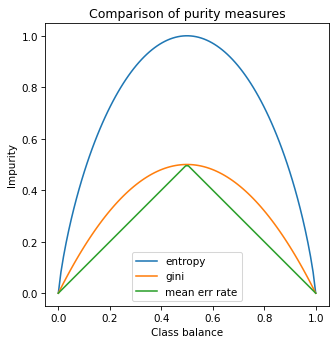

In [5]:
# @title Purity function comparison
This is a homework assignment


Let's re-evaluate the split along `petal length` using gini and entropy criterions. We can see that this time the impurity attains an optimum value at $2.5$, a location which splits out all setosas. The next local optimum is near $5$ where the versicolors can be separated from the virginicas.

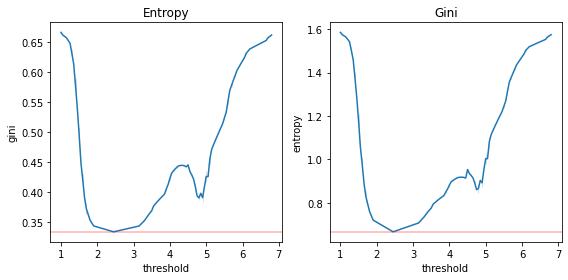

In [6]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_numerical_split_purity(iris_df, "petal length (cm)", gini)
plt.title("Entropy")
plt.subplot(122)
plot_numerical_split_purity(iris_df, "petal length (cm)", entropy)
plt.title("Gini")
plt.tight_layout()

Let's now build and visualize the full tree for Irises (restricted only to petal dimensions).

In [7]:
# @title Tree implementation

Tree building code is part of homework


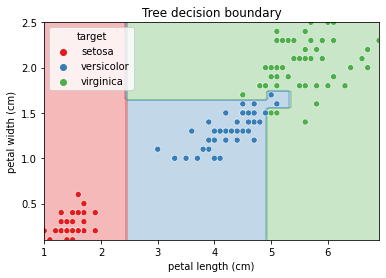

In [8]:
# Dec tree for 2D Iris
iris2d = iris_df[["petal length (cm)", "petal width (cm)", "target"]]
iris2d_tree = Tree(iris2d, print_info=True)
draw_tree_boundary(iris2d_tree)

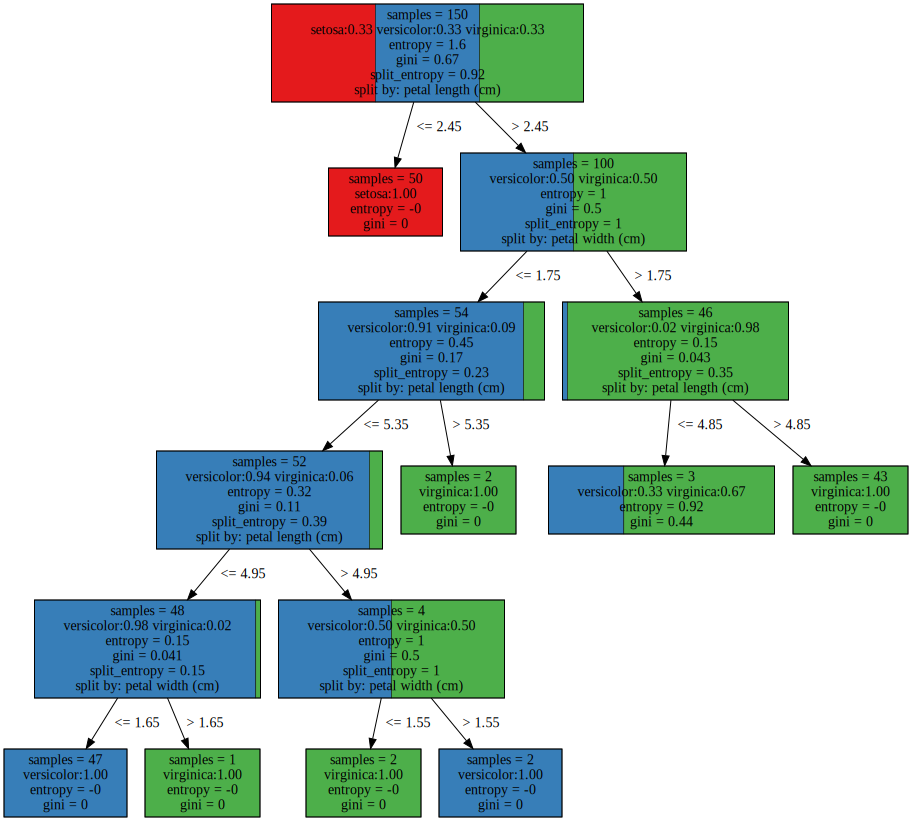

In [9]:
# Plot the tree itself
iris2d_tree.draw()

We can see that the tree indeed first chooses to separate the Setosas and then uses several splits to draw the boundary between Versiciors and Virginicas.

## Detour: a more detailed look at entropy

Let $X$ be a discrete random variable (RV) taking values from set $\mathcal{X}$ with probability mass function $P(X)$.

*Definition* the entropy $H(X)$ of the discrete random variable $X$ is
\begin{equation}
H(X) = \sum_{x\in\mathcal{X}}P(X = x)\log \frac{1}{P(X = x)} = -\sum_{x\in\mathcal{X}}P(X = x)\log P(X = x).
\end{equation}

How to make sense out of this definition? We will, rather informally, argue below that the entrpy of an RV provides a lower bound on the amount of information provided by the RV, which we'll dfine as the average number of bits required to transmit the value the RV has taken.

As a motivating example suppose you have a friend who is a scuba diver, and while they are scubadiving they have a sensor which transmits to you what are the underwater conditions. The probabilities of their answers are given in the table below:

| $x$      | $P(x)$ |
|----------|--------|
| OK       | $1/2$  |
| Average  | $1/4$  |
| Bad      | $1/8$  |
| Terrible | $1/8$  |

To transmit the answer of your friend's sensor you must introduce an *encoding*, e.g.:

| $x$      | $P(x)$ | Code 1 |
|----------|--------|--------|
| OK       | $1/2$  | 00     |
| Average  | $1/4$  | 01     |
| Bad      | $1/8$  | 10     |
| Terrible | $1/8$  | 11     |

Under this encoding, we spend 2 bits per answer.

However, we could also consider a variable length code, that uses shorter codewords for more frequent symbols:

| $x$      | $P(x)$ | Code 2 |
|----------|--------|--------|
| OK       | $1/2$  | 0      |
| Average  | $1/4$  | 10     |
| Bad      | $1/8$  | 110    |
| Terrible | $1/8$  | 111    |

Under this encoding the average number of bits to encode an answer is:
\begin{equation}
\mathbb{E}[L] = \frac{1}{2} \cdot 1 + \frac{1}{4} \cdot 2 + \frac{1}{8} \cdot 3 + \frac{1}{8} \cdot 3 = \frac{7}{4}
\end{equation}

Thus, the new code is (on the average) more efficient. Is it the best we can do?

### The code space

We'll now try formalize the coding task, i.e. the assignment of code lengths to possible values of the RV. 

Let's first observe an important property of our code: in a variable length coding, no codeword can be the prefix of another one. Otherwise, decoding is not deterministic. Therefore, whenever a value is assigned a symbol of length $L$, $1/2^L$ of the code space is reserved and not available to other codes.

This can be visualised as a code space. Below, we indicate the codes assigned to symbols in the example and  grey-out codes that are not available because the shorter codes are used:

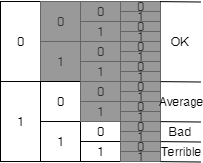

We can observe, that the length 1 code for "OK" uses $1/2$ of the available codes, the length 2 code for "Average" uses $1/4$ and the two length 3 codes for "Bad" and "Terrible" each use $1/8$ of the code space.

In general, a code of length $L$ uses $1/2^L$ of the code space. Equivalently, assigning a fraction $f$ of the code space to a symbol makes it use a symbol of length $L=\log_2(1/f)$.

Assuming that we assign a fraction of a bit to a symbol, our optimal coding problem can be formulated as partitioning the code space into four regions (one for each value of the RV) such that the average length of the code is minimized. 

Formally, let $p_1, p_2, p_3, p_4$ be the probabilities asigned to the 4 symbols and let $f_1, f_2, f_3, f_4$ be the coding space fractions assigned to them.

We want to:
\begin{align}
\text{minimize } &p_1 \log_2 \frac{1}{f_1} +  p_2 \log_2 \frac{1}{f_2} + p_3 \log_2 \frac{1}{f_3} + p_4 \log_2 \frac{1}{f_4} \\
\text{subject to: } & f_1 + f_2 + f_3 + f_4 = 1
\end{align}

For simplicity, we will solve this problem for the case of only two symbols:
\begin{align}
\text{minimize } &p_1 \log_2 \frac{1}{f_1} +  p_2 \log_2 \frac{1}{f_2} \\
\text{subject to: } & f_1 + f_2 = 1
\end{align}

Notice first that $p_2 = 1-p_1$ and likewise $f_2 = 1-f_1$. Then our minimization objective becomes
\begin{equation}
\text{minimize } C = p_1 \log_2 \frac{1}{f_1} +  (1-p_1) \log_2 \frac{1}{1-f_1} 
\end{equation}

To get the minimum over $f_1$ we compute the derivative of the expression with respect to $f_1$ and set it to zero:
\begin{equation}
\frac{\partial C}{\partial f_1} = \frac{p_1}{\log 2}\frac{-1}{f_1} + \frac{1 - p_1}{\log 2}\frac{1}{1 - f_1}
\end{equation}

Multiplying both sides by $\log 2 f_1 (1- f_1)$ we obtain:
\begin{align}
p_1(1-f_1) &= (1-p_1)f_1 \\
p_1 - p_1f_1 & =f_1 - p_1f_1 \\
f_1 &= p_1
\end{align}

Thus, the optimal fraction of code space allocated to symbol 1 is $p_1$, the probability assigned to this symbol and the optimal code length is $\log_2(\frac{1}{p_1})$!

We now see, that the entropy 
\begin{equation}
H(X) = \sum_{x\in\mathcal{X}}P(X)\log \frac{1}{P(X)}
\end{equation}
is simply the average code length!

### General $n$
For general $n$ the reasoning has to be as follows. Jensen's Inequality states that whenever $g$ is convex, and $\alpha_i$s sum up to 1, then
\begin{equation}
\sum_{i=1}^n \alpha_i g(x_i) \geq g\left(\sum_{i=1}^n \alpha_i x_i\right)
\end{equation}

Function $g(t) \mapsto t \lg t$ is strictly convex, and so from Jensen's:
\begin{align}
&\ \sum_{i=1}^n p_i \lg \frac{p_i}{f_i}  \\
= &\ \sum_{i=1}^n f_i \cdot \frac{p_i}{f_i} \lg \frac{p_i}{f_i} \\
= &\ \sum_{i=1}^n f_i \cdot g\left(\frac{p_i}{f_i}\right)\\
\geq &\ g\left( \sum_{i=1}^n f_i \cdot \frac{p_i}{f_i}\right)\\
= &\ g\left( \sum_{i=1}^n p_i\right)\\
= &\ g\left( 1\right) = 0\\
\end{align}
Since
\begin{align}
0 \leq \sum_{i=1}^n p_i \lg \frac{p_i}{f_i} = \sum_{i=1}^n p_i \lg \frac{1}{f_i} + \sum_{i=1}^n p_i \lg 
p_i
= \sum_{i=1}^n p_i \lg \frac{1}{f_i} - \sum_{i=1}^n p_i \lg \frac{1}{p_i} 
\end{align}
we get that $\sum_{i=1}^n p_i \lg \frac{1}{f_i}$ cannot be smaller than $\sum_{i=1}^n p_i \lg \frac{1}{p_i}$. And on the other hand seting $f_i := p_i$ reaches this minimum.


### A note about logarithm basis

It is custommary to compute the entropy using natural logarithms, which gives its value in "nats". If $\log_2$ were used, the entropy has units of bits and corresponds and lowerbounds the average amount of bits needed to transmit a value of the RV.


### Conditional Entropy and Mutual Information

We can compute the expectation of entropy of a random variable $Y$ when conditioned on $X$. We call this value the _conditional entropy_:
$$
\begin{split}
H(Y|X) &= \mathbb{E}_{x}[H(Y|X=x)] = \\
&=\sum_x p(x)H(Y|X=x) = -\sum_x p(x)\sum_y p(y|x)\log p(y|x).
\end{split}
$$

If $Y$ and $X$ are related, the conditional entropy $H(Y|X)$ will be lower than the entropy $H(Y)$, because intuitivelly, knowing $X$ tells us something about $Y$, and hence, the randomness (entropy) must decrease. The difference between the marginal entropy of $Y$ and the conditional entropy is called the _mutual information_ between $Y$ and $X$:

$$
\begin{split}
I(X;Y) &\equiv H(Y) - H(Y|X) \equiv \\
&\equiv H(Y) - H(Y|X) \equiv \\
&\equiv H(X) - H(X|Y) \equiv \\
&\equiv H(X) + H(Y) - H(Y, X) \equiv \\
&\equiv H(Y, X) - H(Y|X) - H(X|Y)
\end{split}
$$

Mutual information is 0 if and only if the two variables are independent. Unlike correlation, it is sensitive to all kinds of dependencies. However, it is harder to compute, especially between continuous variables.

The above relations between the entropies and mututal information are easy to remeber by inspecting their [Wenn diagram](https://en.wikipedia.org/wiki/Mutual_information):

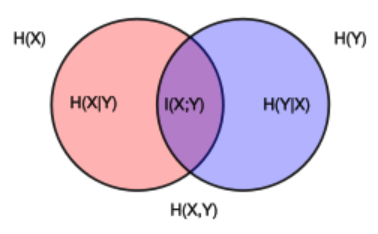

### Entropy properties (for discrete RV)

* $H(X) \geq 0$: the entropy (for a discrete random variable) is always non-negative

* $H(Y|X) = 0$ iff $Y$ is fully specified by $X$

* $H(Y|X) = H(Y)$ iff $Y$ and $X$ are independent.

* $H(X,Y) \leq H(X) + H(Y)$.


### Entropy for continuous RV

The analog of entropy for continuous variables is called _differntial entropy_:

$$
H(X) = -\int f_X(x)\log f_X(x) dx.
$$

Unlike entropy, differential entropy can be negative!

### Entropy and Decision Trees

In the homework assignment you were given a set of 12 balls, in which 11 were identical and 1 was odd (either heavier or lighter). The task was to provide the shortest sequence of measurements using a balance that would indicate the odd ball.

This is similar to building Decision Trees - each step of your procedure performs a test on the balls, and rules out some possibilities. One strategy to perform the tests is to maximize the entropy of the outcome. Consider two variants for the first weighting:
1. you split the balls into two sets of 6, which you weigth against each other.
2. you split the balls into 3 sets of 4, put one aside and weight the remaining two against each other.

The first case can have two outcomes:
1. Left scale goes down
2. Right scale goes down

Both are equally probable and the entropy of the outcome is exactly 1 bit.

On the other hand, the second strategy can have three outcomes:
1. the balance is even, with probability 1/3 (happens if the odd ball is one of the 4 which were left out)
2. the left scale goes down, with prob $2/3 \cdot 1/2 = 1/3$ (there is 2/3 chance that the balanace will not be even, both cases are equally probable).
3. the right scale goes down, again with prob 1/3.

The entropy for this weighting is $\log2(3)=1.58$ bits.

Thus, the seond split conveys more information. Additionally, before the weightings begin the entropy of the system is $\log_2(24)=4.58$ bits (all twelve balls are odd with the same probabitlity and we don't know if the odd ball is lighter or heavier). Maximum information gained with one weighting is 1.58, thus we can't do better than 3 weightings. However, to reach this result, all weightings must be chosen close to optimal.

Let's now get back to Decision Trees in Machine Learning.
Consider a tree node $T$ split into child nodes $C_1, C_2, ..., C_N$ using a splitting criterion $S$.

Let $H(T)$ be the entropy of the targets in node $T$ and $H(C_i)$ be the entropy of the targets in the child node $C_i$.

We have measured split purity as the mean entropy of the children:
$$ 
P = \sum_i \frac{|C_i|}{|T|}H(C_i).
$$

This is the same as the conditional entropy of the classification target, given the split variable. Moreover, the difference between the node's entropy and the mean child entropy is, by definition, the mutual information betweeen the class targets and the splitting variable. Therefore decision trees can be interpreted to perform a greedy, local feature selection based on the mutual information between the split variable and the target!


# What about regression?

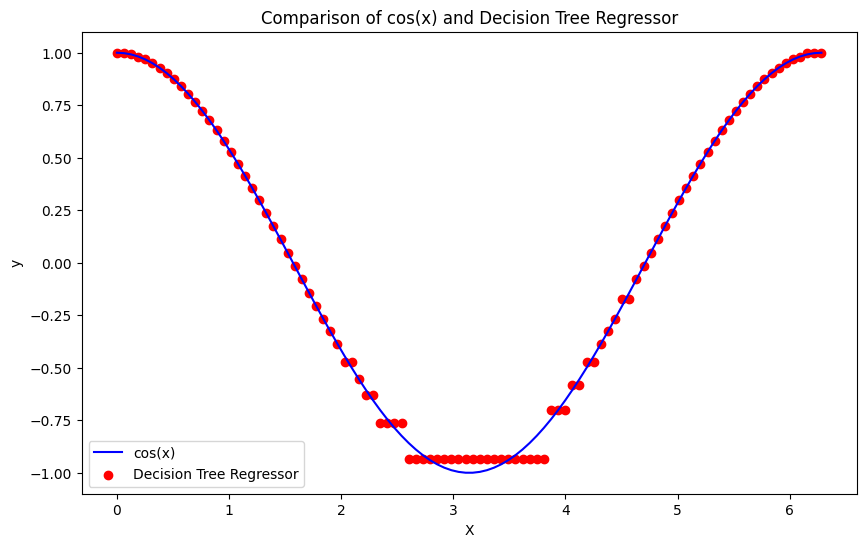

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Generate dataset
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)  # X values
y = np.cos(X).ravel()  # y values (cos(x))


# Create and train the decision tree regressor from scratch
regressor = DecisionTreeRegressor(max_depth=7)
regressor.fit(X, y)

# Predict on the generated dataset
y_pred = regressor.predict(X)

# Plotting both the cos(x) and the decision tree regressor predictions
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='cos(x)', color='blue')
plt.scatter(X, y_pred, label='Decision Tree Regressor', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of cos(x) and Decision Tree Regressor')
plt.legend()
plt.show()


### Entropy Further Reading
1. Chris Olah "Visual Information theory": https://colah.github.io/posts/2015-09-Visual-Information/
2. JA Thomas ad TM Cover, "Elements of Information Theory", chapter 2